## Project goal

Artificial intelligence (AI) has the potencial to revolutionize desease diagnosis and management by performing classification difficult for human exprtes and by rapidly reviewing immense amount of images. In this project, based on the article Kermany (2018), our objective is to classify individuals with pneumonia. After this first phase, our idea is to identify the cause of the pneumonia, whether it is viral or bacterial.

### Dataset description

The dataset is organized into 2 folders (train, test) and contains subfolders for each image category (pneumonia/normal). There are 5,863 X-Ray images (JPEG) and 2 categories (pneumonia/normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checkd by a third expert.

Reference: Kermany, Daniel S., et al. "Identifying medical diagnoses and treatable diseases by image-based deep learning." Cell 172.5 (2018): 1122-1131.

## Importing files

In [3]:
# Testing connection with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Libraries used
from pathlib import Path
import pandas as pd

# Defining path to the data directory
data_dir = Path('drive/MyDrive/pneumonia-detection/chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

## Labeling types of pneumonia

In [5]:
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases_virus = pneumonia_cases_dir.glob('*virus*.jpeg')
pneumonia_cases_bacteria = pneumonia_cases_dir.glob('*bacteria*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the virus pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases_virus:
    train_data.append((img, 1))

# Go through all the bacteria pneumonia cases. The label for these cases will be 2
for img in pneumonia_cases_bacteria:
    train_data.append((img, 2))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# New labels to differentiate the type of pneumonia
train_data['has_pneumonia'] = train_data['label'].apply(lambda x: 1 if x != 0 else 0)
train_data['is_viral'] = train_data['label'].apply(lambda x: 1 if x == 1 else 0)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label,has_pneumonia,is_viral
0,drive/MyDrive/pneumonia-detection/chest_xray/t...,2,1,0
1,drive/MyDrive/pneumonia-detection/chest_xray/t...,1,1,1
2,drive/MyDrive/pneumonia-detection/chest_xray/t...,0,0,0
3,drive/MyDrive/pneumonia-detection/chest_xray/t...,2,1,0
4,drive/MyDrive/pneumonia-detection/chest_xray/t...,0,0,0


## Viewing database samples

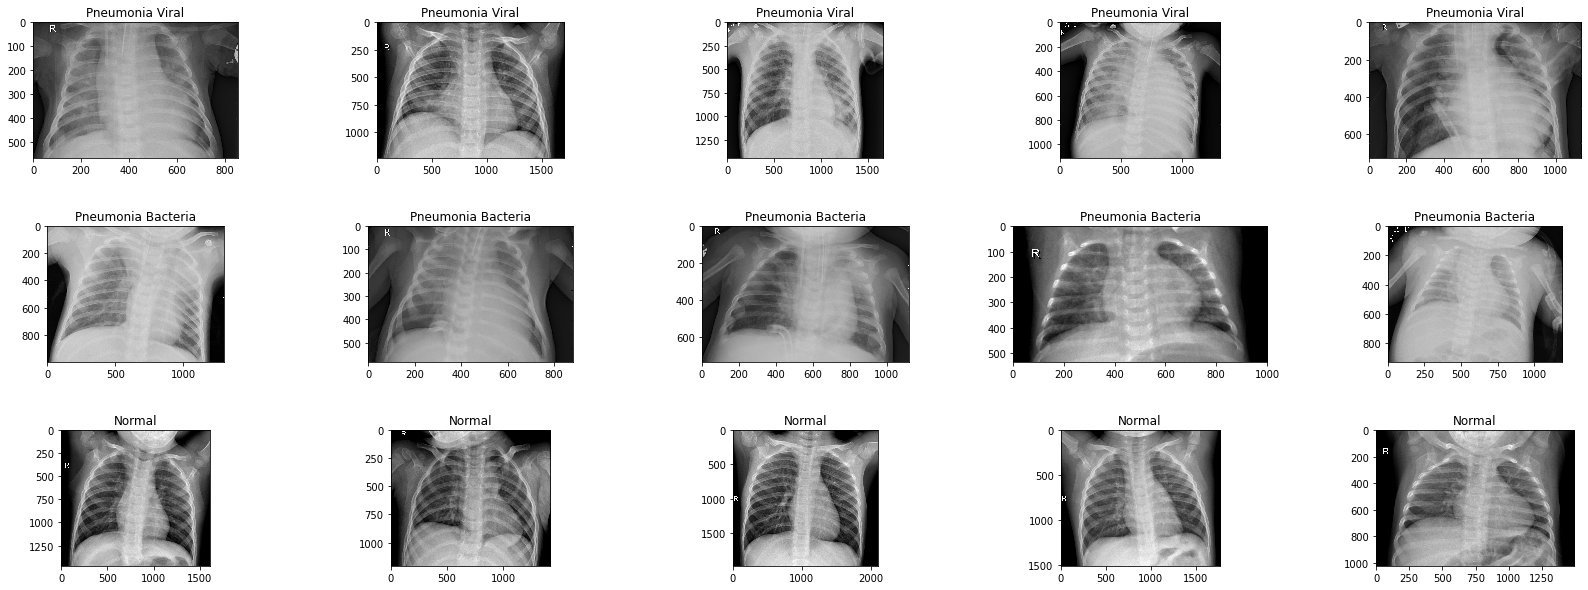

In [6]:
from skimage.io import imread
from pylab import *

# Get few samples for both the classes
virus_pneumonia_samples = (train_data[train_data['is_viral']==1]['image'].sample(n=5, replace=True, random_state=1)).tolist()
bacteria_pneumonia_samples = (train_data[(train_data['has_pneumonia']==1) & (train_data['is_viral']==0)]['image'].sample(n=5, replace=True, random_state=1)).tolist()
normal_samples = (train_data[train_data['has_pneumonia']==0]['image'].sample(n=5, replace=True, random_state=1)).tolist()

# Concat the data in a single list 
samples = virus_pneumonia_samples + bacteria_pneumonia_samples + normal_samples

# Plot the data 
fig, ax = plt.subplots(3,5, figsize=(30,10))
fig.subplots_adjust(hspace = .5, wspace=.001)

ax = ax.ravel()

for i in range(15):
    img = imread(samples[i])
    ax[i].imshow(img, cmap='gray', interpolation='none')

    if i<=4:
        ax[i].set_title("Pneumonia Viral")
    
    elif i>4 and i<=9:
        ax[i].set_title("Pneumonia Bacteria")
    
    else:
        ax[i].set_title("Normal")    

plt.show()

#https://www.askpython.com/python/examples/display-images-using-python

## Exploratory Data Analysis

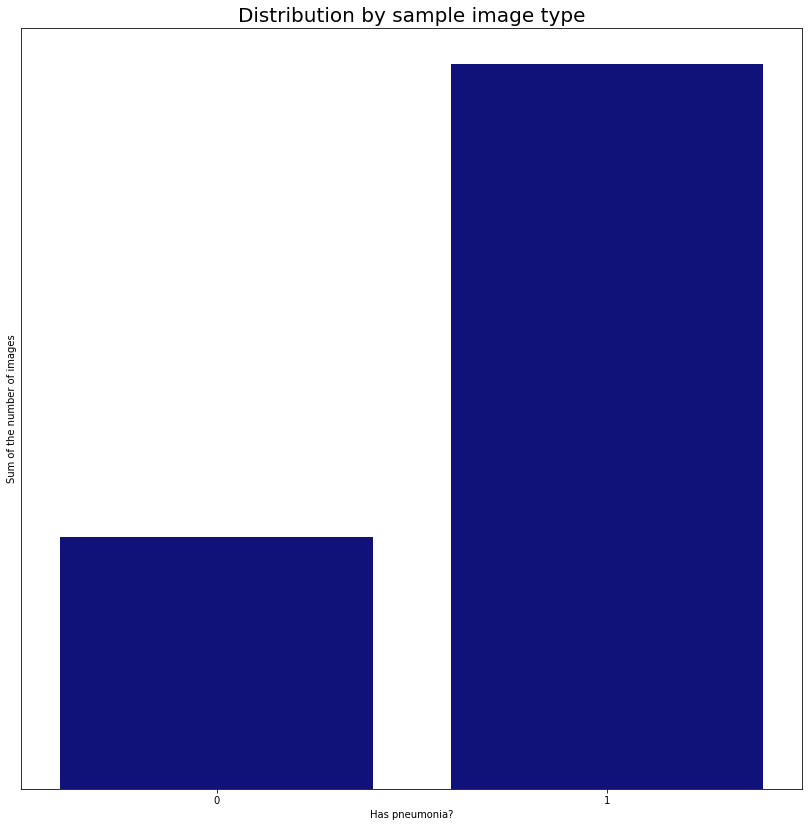

In [12]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set the figure size
plt.figure(figsize=(14, 14))

# Summarizing values with groubpy for pneumonia and type of pneumonia 
total_pneumonia = train_data.groupby('has_pneumonia').count().reset_index()
total_pneumonia = total_pneumonia[['has_pneumonia', 'label']].rename(columns={"label": "total"})
total_virus = train_data.groupby('is_viral').sum().reset_index()
total_virus = total_virus[['has_pneumonia']].rename(columns={'has_pneumonia': 'is_viral'})

# Barchart definition
graph = sns.barplot(x="has_pneumonia",  y="total", data=total_pneumonia, color='darkblue')

# Customizing the axes and title
graph.set_title("Distribution by sample image type", fontsize=20)
graph.set_ylabel("Sum of the number of images")
graph.set_xlabel("Has pneumonia?")

# Labeling bars in the graph
#for i in graph.containers:
#    graph.bar_label(i, fmt='%.2f', label_type='edge')

# Choosing styles
graph.set_yticks([])
graph.set_facecolor('white')

# show the graph
plt.show()

In [8]:
perc_virus_pneumonia = (total_virus/total_virus.sum()*100).reset_index().iloc[-1,1]

print(f'Of the total number of images with pneumonia, about {perc_virus_pneumonia:.2f}% is caused by a virus')

Of the total number of images with pneumonia, about 34.64% is caused by a virus


As we can see in the EDA, there is an imbalance in the database between people who have pneumonia and those who do not. In the first case, we have about three times more data sample. We also need to highlight that this imbalance persists in the sample for the causes of pneumonia, viruses and bacteria, in the same proportion.

In [ ]:
#!python -m pip install -U scikit-image

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba2dea97-c1ac-4535-827d-4d7a0e7e5200' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>